# KaggleX Challenge Notebook

This notebook holds the code for the KaggleX Challenge. The challenge is to predict the price of used cars based on the given features. The dataset is taken from the Kaggle competition [here](https://www.kaggle.com/competitions/kagglex-cohort4/data).

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression


In [61]:
# Load the data
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
sample_submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

# Check for missing values
train_missing = train.isnull().sum()
test_missing = test.isnull().sum()
print(f'Missing values in train: {train_missing.sum()}')
print(f'Missing values in test: {test_missing.sum()}')

# Check uniques
train_one_unique = train.columns[train.nunique() == 1]
test_one_unique = test.columns[test.nunique() == 1] 
print(f'Columns with one unique value in train: {train_one_unique.values}')
print(f'Columns with one unique value in test: {test_one_unique.values}') 

# Drop columns with one unique value (clean_title)
train = train.drop(train_one_unique, axis=1)
test = test.drop(test_one_unique, axis=1)

# Drop engine, colors and model features as too many unique values (not useful for model)
train = train.drop(['engine', 'model', 'ext_col', 'int_col'], axis=1)
test = test.drop(['engine', 'model', 'ext_col', 'int_col'], axis=1)

train.head(3)


Missing values in train: 0
Missing values in test: 0
Columns with one unique value in train: ['clean_title']
Columns with one unique value in test: ['clean_title']


,brand,model_year,milage,fuel_type,transmission,accident,price
id,,,,,,,
0,Ford,2018,74349,Gasoline,10-Speed A/T,None reported,11000
1,BMW,2007,80000,Gasoline,6-Speed M/T,None reported,8250
2,Jaguar,2009,91491,Gasoline,6-Speed A/T,None reported,15000


In [92]:
# Check if test transmissions are in train
transmissions = test.transmission.unique()

for transmission in transmissions:
    if transmission not in train.transmission.unique():
        print(f'Transmission {transmission} is not in train')

# Check if test fuel types are in train
fuel_types = test['fuel_type'].unique()

for fuel_type in fuel_types:
    if fuel_type not in train['fuel_type'].unique():
        print(f'Fuel type {fuel_type} is not in train')

# Check if test breands are in train
brands = test.brand.unique()

for brand in brands:
    if brand not in train.brand.unique():
        print(f'Brand {brand} is not in train')


Transmission 2 is not in train
Transmission Manual is not in train
Brand Saab is not in train
Brand smart is not in train


In [62]:
# Binarize features with only two unique values (accident)
binary_features = [col for col in train.columns if train[col].nunique() == 2]
for col in binary_features:
    mapper = {train[col].unique()[0]: 0, train[col].unique()[1]: 1}
    train[col] = train[col].replace(mapper)
    test[col] = test[col].replace(mapper)

train.head(3)

,brand,model_year,milage,fuel_type,transmission,accident,price
id,,,,,,,
0,Ford,2018,74349,Gasoline,10-Speed A/T,0,11000
1,BMW,2007,80000,Gasoline,6-Speed M/T,0,8250
2,Jaguar,2009,91491,Gasoline,6-Speed A/T,0,15000


In [64]:
# Standardize numerical features
scaler_milage = StandardScaler()
scaler_price = StandardScaler()
train_standardized = train.copy()
test_standardized = test.copy()
train_standardized['milage'] = scaler_milage.fit_transform(train['milage'].values.reshape(-1, 1))
train_standardized['price'] = scaler_price.fit_transform(train['price'].values.reshape(-1, 1))
test_standardized['milage'] = scaler_milage.transform(test['milage'].values.reshape(-1, 1))


test_standardized.head(3)

,brand,model_year,milage,fuel_type,transmission,accident
id,,,,,,
54273,Mercedes-Benz,2014,0.005029,Gasoline,A/T,0
54274,Lexus,2015,1.095441,Gasoline,8-Speed A/T,0
54275,Mercedes-Benz,2015,-0.411404,Gasoline,7-Speed A/T,0


In [86]:
# Vectorize train features
vectorizer = DictVectorizer(separator='_', sparse=False)
train_features = vectorizer.fit_transform(train_standardized.reset_index(drop=False).to_dict(orient='records'))
train_encoded = pd.DataFrame(train_features, columns=vectorizer.feature_names_)
train_encoded.set_index('id', inplace=True)
test_features = vectorizer.transform(test_standardized.reset_index(drop=False).to_dict(orient='records'))
test_encoded = pd.DataFrame(test_features, columns=vectorizer.feature_names_).drop('price', axis=1)
test_encoded.set_index('id', inplace=True)
test_encoded.head(3)

,accident,brand_Acura,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,...,transmission_Automatic CVT,transmission_CVT Transmission,transmission_CVT-F,transmission_F,transmission_M/T,transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–
id,,,,,,,,,,,,,,,,,,,,,
54273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


RMSE: 0.9394826836635771


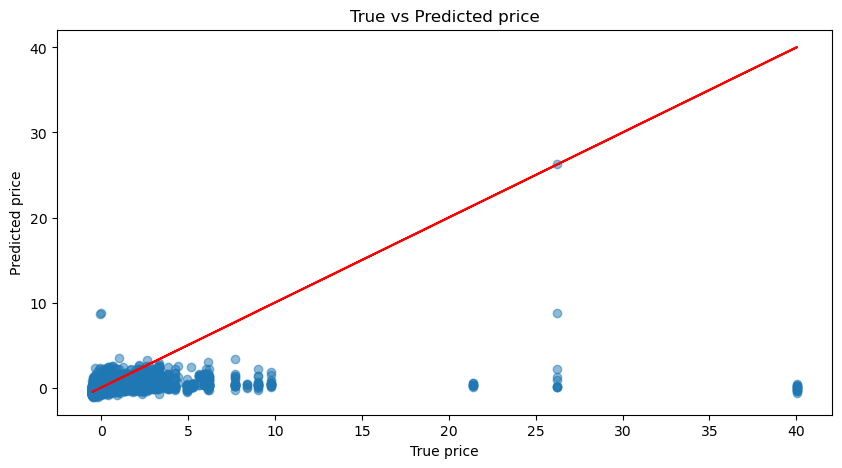

In [87]:
# Try to predict price with linear regression
X = train_encoded.drop('price', axis=1)
y = train_encoded['price']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate RMSE
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
print(f'RMSE: {rmse}')

# Plot predictions
plt.figure(figsize=(10, 5))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot(y, y, color='red')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.title('True vs Predicted price')
plt.show()

In [89]:
# Try to predict price with random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(n_estimators=100, random_state=0)
# scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
# rmse = np.sqrt(-scores)
# print(f'RMSE: {rmse.mean()}')

In [ ]:
# Train the model
model.fit(X, y)
y_pred = model.predict(X)

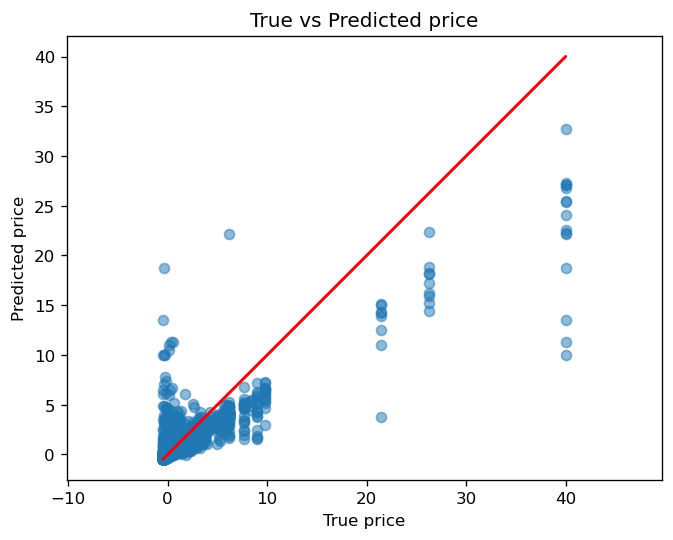

In [95]:
# Plot predictions
plt.figure(dpi=120)
plt.scatter(y, y_pred, alpha=0.5)
plt.plot(y, y, color='red')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.title('True vs Predicted price')
plt.axis('equal')
plt.show()

In [97]:
# Predict test data
y_test = model.predict(test_encoded)
submission = sample_submission.copy()
submission['price'] = scaler_price.inverse_transform(y_test.reshape(-1, 1))
submission.to_csv('../data/submission1.csv')
submission.head(3)

,price
id,
54273,17024.490
54274,30475.560
54275,54883.485
